<a href="https://colab.research.google.com/github/manvendra7/END2.0_Assignment6/blob/main/Encoder_Decoder_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading Of Data

In [ ]:
import pandas as pd
df = pd.read_csv("/content/tweets.csv")
df.head()

,tweets,labels
0,Obama has called the GOP budget social Darwini...,1
1,"In his teen years, Obama has been known to use...",0
2,IPA Congratulates President Barack Obama for L...,0
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0
4,RT @wardollarshome: Obama has approved more ta...,1


In [ ]:
# Data Statistics
df.labels.value_counts()

0    931
1    352
2     81
Name: labels, dtype: int64

In [ ]:
import random
import torch, torchtext
from torchtext import data

In [ ]:
# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [ ]:
Tweet = torchtext.legacy.data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = torchtext.legacy.data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [ ]:
fields = [('tweet', Tweet), ('label', Label)]

In [ ]:
example = [torchtext.legacy.data.Example.fromlist([df.tweets[i],df.labels[i]], fields) for i in range(df.shape[0])] 

In [ ]:
twitterDataset = torchtext.legacy.data.Dataset(example, fields)

In [ ]:
# Train-Test Split 
(train, valid) = twitterDataset.split(split_ratio=[85, 15], random_state = random.seed(SEED))

In [ ]:
#Train and Test size
len(train), len(valid)

(1159, 205)

In [ ]:
vars(train.examples[11])

{'label': 1,
 'tweet': ['@sweetbay',
  'That',
  'was',
  'Paul',
  'Ryan',
  "'s",
  'budget',
  '.',
  'How',
  'did',
  'Obama',
  "'s",
  'budget',
  'do',
  '?',
  'Getting',
  'educated',
  'on',
  'the',
  'facts',
  'is',
  'the',
  'first',
  'step',
  'in',
  'losing',
  'that',
  'liberalism',
  '!']}

In [ ]:
# Building the vocabulary
Tweet.build_vocab(train)
Label.build_vocab(train)

In [ ]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  4651
Size of label vocab :  3
Top 10 words appreared repeatedly : [('Obama', 1069), (':', 783), ('#', 780), ('.', 761), (',', 598), ('"', 550), ('the', 542), ('RT', 516), ('?', 419), ('to', 400)]
Labels :  defaultdict(None, {0: 0, 1: 1, 2: 2})


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# Bucket Iterator 
train_iterator, valid_iterator = torchtext.legacy.data.BucketIterator.splits((train, valid), batch_size = 32, 
                                                            sort_key = lambda x: len(x.tweet),
                                                            sort_within_batch=True, device = device)

In [ ]:
trn_iter = next(iter(train_iterator))

In [ ]:
trn_iter.label

tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

# Encoder

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super().__init__()          
    
    # Embedding layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    
    # LSTM layer
    self.rnn = nn.LSTM(embedding_dim, 
                       hidden_dim,
                       #dropout=dropout,
                       batch_first=True)


  def forward(self, text, text_lengths):
    
    # text = [batch size, sent_length]
    embedded = self.embedding(text)
    # embedded = [batch size, sent_len, emb dim]
  
    # packed sequence
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)

    packed_output, (hidden_encoder, cell_encoder) = self.rnn(packed_embedded)

    encoder_output, encoder_output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
    
    # Printing of Encoder Hidden State
    c = 0
    for i,x in enumerate(encoder_output[0]):
      print("Hidden State of Encoder at timestamp: {} ".format(c))
      print(x)
      print("Shape of the Hiden state: ", x.shape)
      print("*"*100)
      c = c+1

    return encoder_output

# Decoder

In [ ]:
class Decoder(nn.Module):

# Define all the layers used in model
  def __init__(self, vocab_size, encoder_output_dim, hidden_dim, output_dim=16):
    
    super().__init__()          
    
    # LSTM layer
    self.rnn = nn.LSTM(encoder_output_dim, 
                       hidden_dim, 
                       batch_first=True)

    self.fc = nn.Linear(hidden_dim, output_dim)


  def forward(self, encoder_output,debug=False,steps = 5):
    
    
    output, (hidden_decoder, cell_decoder) = self.rnn(encoder_output)

    # Printing of Decoder Hidden State
    c = 0
    for i,x in enumerate(output[0]):
      print("Hidden State of Decoder at timestamp: {} ".format(c))
      print(x)
      print("Shape of the Hiden state: ", x.shape)
      c = c+1
      print("*"*100)

    # Linear
    dense_outputs = self.fc(hidden_decoder)   
    
    return dense_outputs

# Encoder-Decoder Model

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, hidden_dim_2, num_classes):
        super().__init__()
 
        self.encoder = encoder
        self.decoder = decoder        
        self.fc = nn.Linear(hidden_dim_2, num_classes)

    def forward(self, text, text_lengths):
        
        encoder_vector = self.encoder(text, text_lengths)

        decoder_vector = self.decoder(encoder_vector)

        output = self.fc(decoder_vector)
        final_output = F.softmax(output[0], dim=1) 

        return final_output

In [ ]:
# Define hyperparameters
vocab_len = len(Tweet.vocab)
embedding_dim = 324
hidden_dim = 144
num_classes=3
encoder_dim = 144
encoder = Encoder(vocab_len,embedding_dim,hidden_dim)
decoder = Decoder(vocab_len, 144,64)
model = EncoderDecoder(encoder,decoder,16,num_classes)

In [ ]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

EncoderDecoder(
  (encoder): Encoder(
    (embedding): Embedding(4651, 324)
    (rnn): LSTM(324, 144, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): LSTM(144, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
The model has 1,832,495 trainable parameters


In [ ]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)

criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer_1, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweet  
        
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths).squeeze()
        
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()  
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweet
            
            # convert to 1d tensor
            predictions = model(tweet, tweet_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 10
best_valid_loss = float('inf')
tl = []
vl = []
ta = []
va = []

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    tl.append(train_loss)
    ta.append(train_acc)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    vl.append(valid_loss)
    va.append(valid_acc)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 1.091 | Train Acc: 27.50%
	 Val. Loss: 1.073 |  Val. Acc: 44.20% 

	Train Loss: 1.021 | Train Acc: 65.55%
	 Val. Loss: 0.941 |  Val. Acc: 68.30% 

	Train Loss: 0.883 | Train Acc: 69.12%
	 Val. Loss: 0.868 |  Val. Acc: 68.75% 

	Train Loss: 0.849 | Train Acc: 70.98%
	 Val. Loss: 0.851 |  Val. Acc: 73.21% 

	Train Loss: 0.819 | Train Acc: 75.88%
	 Val. Loss: 0.849 |  Val. Acc: 73.21% 

	Train Loss: 0.794 | Train Acc: 79.05%
	 Val. Loss: 0.834 |  Val. Acc: 74.11% 

	Train Loss: 0.763 | Train Acc: 82.09%
	 Val. Loss: 0.822 |  Val. Acc: 74.11% 

	Train Loss: 0.734 | Train Acc: 84.88%
	 Val. Loss: 0.816 |  Val. Acc: 77.68% 

	Train Loss: 0.707 | Train Acc: 86.06%
	 Val. Loss: 0.828 |  Val. Acc: 75.89% 

	Train Loss: 0.694 | Train Acc: 86.74%
	 Val. Loss: 0.788 |  Val. Acc: 79.46% 



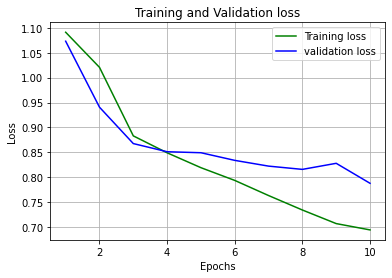

In [ ]:
#  training loss vs validation Accuracy
import matplotlib.pyplot as plt

epochs = range(1,11)
plt.plot(epochs, tl, 'g', label='Training loss')
plt.plot(epochs, vl, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

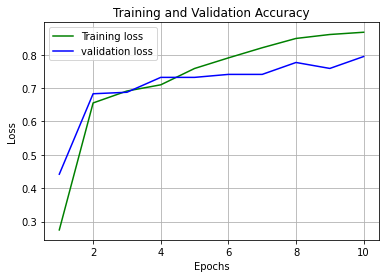

In [ ]:
#  training loss vs validation loss 
import matplotlib.pyplot as plt

epochs = range(1,11)
plt.plot(epochs, ta, 'g', label='Training loss')
plt.plot(epochs, va, 'b', label='validation loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

# Inferencing

In [ ]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet, Actual_label):
    
    categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)
    _, pred = torch.max(prediction, 1) 

    return categories[Actual_label], categories[pred.item()]
    
    
    
    

# Encoder Decoder Hidden State Output

In [ ]:
text = "A valid explanation for why Trump won't let women on the golf course."
Actual_label,predicted  = classify_tweet(text,0)
print("Tweet: {}".format(text))
print("Actual Class: {}".format(Actual_label))
print("Predicted Class: {}".format(predicted))

Hidden State of Encoder at timestamp: 0 
tensor([ 2.0558e-01, -3.2869e-01,  3.4276e-03, -4.3458e-02, -8.2511e-02,
        -1.3851e-01,  7.8022e-03, -2.5605e-01,  1.7949e-04, -3.0466e-01,
        -7.9166e-02,  1.8507e-01, -1.4164e-01, -1.7476e-01, -1.8369e-01,
        -9.7185e-02, -2.2558e-01, -8.9272e-02,  1.8383e-01,  8.3906e-02,
         1.1522e-01,  9.5919e-03,  9.3851e-02,  2.9066e-02,  1.3647e-01,
         4.5100e-02, -5.2948e-02,  9.1896e-02, -1.6769e-03, -7.1356e-02,
         1.6976e-01,  2.2048e-01,  1.7109e-02,  7.3839e-02,  1.1788e-01,
         1.0138e-01,  7.5775e-02, -1.1807e-01,  3.8549e-01, -6.8016e-02,
        -1.2067e-01,  1.2306e-01, -2.9889e-01,  1.5830e-01, -3.1096e-01,
        -9.5559e-02,  1.5872e-02,  3.8510e-02, -6.3837e-02,  1.0239e-01,
        -4.5392e-02,  7.1615e-02, -3.7416e-02,  2.5706e-01, -2.4639e-01,
        -4.1704e-02,  1.8778e-01,  1.5466e-01,  6.9559e-02, -1.3059e-01,
        -1.9550e-01,  1.9060e-01,  2.6823e-02,  2.5676e-01,  1.8295e-01,
        -6

In [ ]:
classify_tweet("A valid explanation for why Trump won't let women on the golf course.",0)

Tweet: A valid explanation for why Trump won't let women on the golf course.
Predicted Class: Negative
Predicted Class: Negative


In [ ]:
# Misclassified Tweets
c=0
for text,label in zip(df.tweets, df.labels):
  Actual_label,predicted  = classify_tweet(text,label)
  if Actual_label!=predicted:
    print("Tweet: {}".format(text))
    print("Actual Class: {}".format(Actual_label))
    print("Predicted Class: {}".format(predicted))
    print("*"*100)
    c +=1
print("Total No of Misclassified Tweets out of 1364 Tweets: ",c)


Tweet: A valid explanation for why Obama won't let women on the golf course.   #WhatsRomneyHiding
Actual Class: Positive
Predicted Class: Negative
****************************************************************************************************
Tweet: #WhatsRomneyHiding? Obama's dignity and sense of humor? #p2 #tcot
Actual Class: Neutral
Predicted Class: Negative
****************************************************************************************************
Tweet: RealClearPolitics - Obama's Organizational Advantage on Full ...: As a small but electorally significant state t... http://t.co/3Ax22aBB
Actual Class: Neutral
Predicted Class: Positive
****************************************************************************************************
Tweet: RT @mlake9: Love how the #Obama campaign's #WhatsRomneyHiding back fired, now #WhatsObamaHiding is trending. Seeing a lot of birth certificate tweets.
Actual Class: Positive
Predicted Class: Negative
******************************

In [ ]:
df.head(1)

,tweets,labels
0,Obama has called the GOP budget social Darwini...,1


In [ ]:
df

,tweets,labels
0,Obama has called the GOP budget social Darwini...,1
1,"In his teen years, Obama has been known to use...",0
2,IPA Congratulates President Barack Obama for L...,0
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0
4,RT @wardollarshome: Obama has approved more ta...,1
...,...,...
1359,@liberalminds Its trending idiot.. Did you loo...,0
1360,RT @AstoldByBass: #KimKardashiansNextBoyfriend...,0
1361,RT @GatorNation41: gas was $1.92 when Obama to...,1
1362,"@xShwag haha i know im just so smart, i mean y...",1
